#**🚀Run the new Meta Llama 3.1-70B Using Groq-API**
Meta Llama 3.1-70B is one of the open source LLM released by meta. It supports 8 Languages `English, German, French, Italian, Portuguese, Hindi, Spanish, and Thai`.

Here we are using Groq API to get access to the model and run it. Since all the inference is done through Groq API, you can run this notebook on the basic `CPU Runtime` without any gpu. And honestly its really fast.

NOTE: The first step🥇 is to get your own [Groq-API](https://console.groq.com/keys) from their website. Just click on the link then sign up and create your own API.

The next step is to copy and save your API key in the `colab secretes tab`.<br> Just paste the API Key into the value section and name it `GROQ_API_KEY`. Something like this... 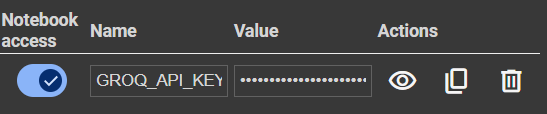

In [ ]:
#@title ##Install Packages📦
from IPython.display import clear_output
!pip install -q groq gradio
clear_output()

In [ ]:
#@title Run Llama 3.1-70B [GradioUI]🚀
#@markdown Simply provide a system role and user input to initiate a chat.<br>
#@markdown `The system role sets the behaviour of the model, You can leave it empty for default behaviour.` <br> `The user input is for the users prompt/message.`

#@markdown This interface comes with some new feature like: <br>
#@markdown 1. Saving your chat history/content into a json file stored in `content/chats`.<br>
#@markdown 2. Whenever you start a chat, the application saves a json file and the filename is created with some random texts picked up from your conversation.<br>
#@markdown 3. You have the option to start a new chat or select from existing ones so that you can continue your topic/chat with the model without loosing any previous data or information you fed into it. Its basically like continuing your chat from wherever you left it off.
#@markdown 4. You can also update the list of available chats. This basically means that when you create a new chat by toggling on the `Start New Chat` option, it creates a new `chat_history json file` but it won't be updated in the `Select Chat` dropdown instantly to do that you need to click on the `Update Chat list` button(its like a refresh buttons for your saved chats).<br>

#@markdown ❗Remember to **Untick✅** the `Start new chat` option if you want to continue in the same chat as you are in or **Else** it will keep on creating new chats everytime you prompt something to the model. So if you want to continue in the same chat then untick the `Start new chat`.

import os
import gradio as gr
from groq import Groq
from google.colab import userdata
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Set up the API key from colab secretes
userdata.get('GROQ_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

chat_directory = "/content/chats"  # Directory to store chat history files
log_file = "/content/error_log.txt"  # Log file for errors
os.makedirs(chat_directory, exist_ok=True)  # Ensure chat directory exists

def log_error(message):
    with open(log_file, "a") as f:
        f.write(message + "\n")

def save_chat_history(chat_history, file_name):
    try:
        with open(file_name, "w") as file:
            json.dump(chat_history, file)
        print(f"Chat history saved to {file_name}")
    except Exception as e:
        log_error(f"Error saving chat history: {e}")

def load_chat_history(file_name):
    try:
        if os.path.exists(file_name):
            with open(file_name, "r") as file:
                return json.load(file)
        else:
            log_error(f"File {file_name} does not exist")
            return []
    except Exception as e:
        log_error(f"Error loading chat history: {e}")
        return []

def extract_keywords(messages):
    try:
        all_text = " ".join(message["content"] for message in messages)
        vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
        X = vectorizer.fit_transform([all_text])
        scores = X.sum(axis=0).A1
        words = vectorizer.get_feature_names_out()
        top_keywords = [words[i] for i in scores.argsort()[-3:]]
        return "_".join(top_keywords)
    except Exception as e:
        log_error(f"Error extracting keywords: {e}")
        return "default_chat"

def get_available_chats():
    try:
        files = os.listdir(chat_directory)
        return [f for f in files if f.endswith('.json')]
    except Exception as e:
        log_error(f"Error getting available chats: {e}")
        return []

def chat_with_llm(system_role, user_input, new_chat, selected_chat):
    try:
        if new_chat:
            chat_history = []
            chat_history.append({"role": "system", "content": system_role})
            keywords = extract_keywords(chat_history)
            unique_file_name = os.path.join(chat_directory, re.sub(r'\W+', '_', keywords) + ".json")
            save_chat_history(chat_history, unique_file_name)
        elif selected_chat:
            unique_file_name = os.path.join(chat_directory, selected_chat) if isinstance(selected_chat, str) else os.path.join(chat_directory, selected_chat[0])
            chat_history = load_chat_history(unique_file_name)
        else:
            unique_file_name = os.path.join(chat_directory, "chat_history.json")
            chat_history = load_chat_history(unique_file_name)

        messages = chat_history + [
            {
                "role": "user",
                "content": user_input,
            }
        ]

        chat_completion = client.chat.completions.create(
            messages=messages,
            model="llama-3.1-70b-versatile",
        )
        reply = chat_completion.choices[0].message.content

        chat_history.append({"role": "user", "content": user_input})
        chat_history.append({"role": "assistant", "content": reply})

        save_chat_history(chat_history, unique_file_name)
        return reply
    except Exception as e:
        log_error(f"Error in chat_with_llm function: {e}")
        return f"Error: {e}"

def update_dropdown():
    try:
        choices = get_available_chats()
        return gr.update(choices=choices)
    except Exception as e:
        log_error(f"Error updating dropdown: {e}")
        return gr.update(choices=[])

# Gradio interface
with gr.Blocks() as GradioUI:
    gr.Markdown("""
    <div style="text-align: center;">
        <h1>Llama 3.1-70B <br> Notebook By <a href='https://github.com/73LIX' target='_blank'>GouravYdv</a></h1>
    </div>
        <p>Llama can make mistakes. Check for important info..</p>
    """)

    system_role = gr.Textbox(label="System Role")
    user_input = gr.Textbox(label="User Input")
    new_chat = gr.Checkbox(label="Start New Chat", value=False)
    selected_chat = gr.Dropdown(choices=get_available_chats(), label="Select Chat", interactive=True)
    chat_output = gr.Textbox(label="Chat Response")

    submit_button = gr.Button("Submit")
    update_button = gr.Button("Update Chat List")

    submit_button.click(chat_with_llm, inputs=[system_role, user_input, new_chat, selected_chat], outputs=chat_output)
    update_button.click(fn=update_dropdown, outputs=selected_chat)

GradioUI.launch()